# Tutorial for `MDRefine` - 3

In these notebooks we are going to perform several different refinements of MD-generated trajectories by employing the package `MDRefine`. In this way, we believe the usage of `MDRefine` will become clear and easy to emulate for your own case of interest. Input data for these examples may be downloaded from Zenodo as indicated in `load_data_oligomers.ipynb`.

We remind you to have a look at our paper https://arxiv.org/pdf/2411.07798 and at the documentation https://www.bussilab.org/doc-MDRefine/MDRefine/index.html.

Required assistance may be opened at https://github.com/bussilab/MDRefine/issues.

In [1]:
import pandas
import os
import numpy as np
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

from MDRefine import load_data, minimizer, hyper_minimizer, MDRefinement

## Usage of `MDRefinement`

Let's see an application of `MDRefinement`, which includes automatic optimization of the hyperparameters, for the refinement of RNA oligomers. This function `MDRefinement` includes both `load_data`, the cross validation procedure (with automatic minimization of the $\chi^2$ on left-out observables / frames) and `minimizer`.

### Load data

Just to show an example of how `MDRefinement` works, you can take 2 molecular systems (AAAA and CAAU, for instance) and avoid loading the unobserved NOEs, which are computationally expensive.

In [3]:
infos = {'global': {
    'path_directory': '../../DATA',
    'system_names': ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs'],  #  , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon','sugar'],
    'obs': ['NOEs'],  # , 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 100

- define the forward model (include also the possibility for selected_obs, namely, to compute only selected observables in cross validation)

In [4]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [5]:
infos['global']['forward_model'] = forward_model_fun

- choose among force-field correction on $\alpha,\zeta$ or only on $\alpha$ dihedral angles, for example let's take the second

In [6]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

- load the data

In [7]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA


loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


- define also the regularizations of the forward model (user-defined) and the force-field correction (Kullback-Leibler divergence)

In [8]:
def forward_model_regularization(coeffs, coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [9]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### Case 1: ensemble + forward-model refinement

Apply separately `hyper_minimizer` and then `minimizer` at optimal values of the hyperparameters, or just `MDRefinement`. Then, analyse the results.

#### a. search for the optimal hyperparameters

- select starting values for the hyperparameters ($+\infty$ if no refinement in that direction);
- select also how to optimize the hyperparameters, namely, if you want to minimize the $\chi^2$ on `which_set = 'validation'` (left-out frames) or `'test'` (left-out observables); `'validation'` by default;
- select `random_states`, namely, how many splitting in cross validation.

In [10]:
starting_alpha = 1
starting_beta = np.inf
starting_gamma = 1

which_set = 'test'
random_states = 2

In [11]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=starting_alpha,
    starting_beta=starting_beta, starting_gamma=starting_gamma, random_states=random_states,
    which_set=which_set)

Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 0.0), ('gamma', 0.0)]
av. chi2:  1876.8672759147148
av. gradient:  [-6972.42087039   648.39210417]

log10 hyperpars:  [('alpha', 0.995703917934301), ('gamma', -0.09259431845573829)]
av. chi2:  221.7471005423148
av. gradient:  [-259.50408818   -0.42063849]

log10 hyperpars:  [('alpha', 1.0342087320906077), ('gamma', -0.09239499351829777)]
av. chi2:  213.23030713351847
av. gradient:  [-183.1922357     0.22981086]


In [12]:
hyper_out

          fun: DeviceArray(213.23030713, dtype=float64)
     hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.hyperminimizer.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7f68279d6f28>
          jac: array([-183.1922357 ,    0.22981086])
      message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
         nfev: 3
          nit: 2
         njev: 3
       status: 0
      success: True
            x: array([ 1.03420873, -0.09239499])

In [13]:
opt_alpha, opt_gamma = 10**hyper_out.x

print(opt_alpha, opt_gamma)

10.819538386857847 0.8083603559933956


#### b. search for optimal coefficients at optimized hyperparameters

In [14]:
Result = minimizer(data, regularization=regularization, alpha=opt_alpha, gamma=opt_gamma)

New evaluation:
loss:  170.95712419558632
gradient:  [ 0.19221512  0.6858571   1.12410564 -5.28740227 -5.17315263 -3.00402738
 12.4482233  -3.08106231 21.41154846] 

New evaluation:
loss:  161.72668672667228
gradient:  [-1.65461642e-01  1.59094471e-01 -3.82392503e-03 -2.19003328e+00
 -1.00370359e+00  3.81867547e+00 -3.57821715e+00  4.38672524e-01
 -7.97681534e+00] 

New evaluation:
loss:  156.34912493474104
gradient:  [-2.20264109 -2.91853504 -6.47540147  2.03939267  4.82221665  6.33258757
  1.74002865  4.35360179  2.33999457] 

New evaluation:
loss:  159.89075352759448
gradient:  [  1.83424486   2.51642184   5.92548649  -4.11691039  -3.60082066
 -12.69434702   0.20693054   1.77132668   0.70171693] 

New evaluation:
loss:  154.31257319759277
gradient:  [-0.68666528 -0.89827133 -1.83598189 -0.28628566  1.60593582 -0.90383186
  1.169886    3.38307693  1.72730207] 

New evaluation:
loss:  158.65275943057833
gradient:  [ 1.54294753  2.17668958  5.05805396  3.31802671  6.02621925  7.3206702

In [15]:
print(vars(Result).keys())

tot_chi2 = np.sum([item2 for item in Result.chi2.values() for item2 in item.values()])
print('1/2 chi2: ', 1/2*tot_chi2)

print('gamma*R: ', opt_gamma*Result.reg_fm)

tot_DKL = np.sum([l for l in Result.D_KL_alpha.values()])
print('alpha*D_KL: ', opt_alpha*tot_DKL)

loss = opt_gamma*Result.reg_fm + opt_alpha*tot_DKL + 1/2*tot_chi2
print('loss: ', loss)

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])
1/2 chi2:  108.28768973255544
gamma*R:  2.5506178452205286
alpha*D_KL:  41.387837223956126
loss:  152.2261448017321


In [16]:
fm_names = list(data.properties.forward_coeffs_0.keys())
my_fm_coeffs = pandas.Series(Result.pars[-len(fm_names):], index=fm_names)
print(my_fm_coeffs)

A_gamma    10.305907
B_gamma    -1.885682
C_gamma    -0.222326
A_beta     19.256810
B_beta     -5.174642
C_beta     -0.336369
A_sugar     8.610968
B_sugar    -1.864901
C_sugar    -0.217786
dtype: float64


#### c. `MDRefinement`
you can do a. and b. at once with `MDRefinement`

In [17]:
result = MDRefinement(infos, stride=stride, regularization=regularization, starting_alpha=starting_alpha, starting_beta=starting_beta,
    starting_gamma=starting_gamma, random_states=random_states, which_set=which_set, results_folder_name='my_results')

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done

search for optimal hyperparameters ...
Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 0.0), ('gamma', 0.0)]
av. chi2:  1876.8672759147148
av. gradient:  [-6972.42087039   648.39210417]

log10 hyperpars:  [('alpha', 0.995703917934301), ('gamma', -0.09259431845573829)]
av. chi2:  221.7471005423148
av. gradient:  [-259.50408818   -0.42063849]

log10 hyperpars:  [('alpha', 1.0342087320906077), ('gamma', -0.09239499351829777)]
av. chi2:  213.23030713351847
av. gradient:  [-183.1922357     0.22981086]

optimal hyperparameters: alpha: 10.819538386857847 gamma: 0.8083603559933956

refinement with optimal hyperparameters...
New evaluation:
loss:  170.95712419558632
gradient:  [ 0.19221512  0.6858571   1.12410564 -5.28740227 -5.17315263 -3.00402738
 12.4482233  -3.08106

In [18]:
print(vars(Result).keys())

tot_chi2 = np.sum([item2 for item in Result.chi2.values() for item2 in item.values()])
print('1/2 chi2: ', 1/2*tot_chi2)

print('gamma*R: ', opt_gamma*Result.reg_fm)

tot_DKL = np.sum([l for l in Result.D_KL_alpha.values()])
print('alpha*D_KL: ', opt_alpha*tot_DKL)

loss = opt_gamma*Result.reg_fm + opt_alpha*tot_DKL + 1/2*tot_chi2
print('loss: ', loss)

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])
1/2 chi2:  108.28768973255544
gamma*R:  2.5506178452205286
alpha*D_KL:  41.387837223956126
loss:  152.2261448017321


In [19]:
fm_names = list(data.properties.forward_coeffs_0.keys())
my_fm_coeffs = pandas.Series(Result.pars[-len(fm_names):], index=fm_names)
print(my_fm_coeffs)

A_gamma    10.305907
B_gamma    -1.885682
C_gamma    -0.222326
A_beta     19.256810
B_beta     -5.174642
C_beta     -0.336369
A_sugar     8.610968
B_sugar    -1.864901
C_sugar    -0.217786
dtype: float64


#### d. plot refined forward model

In [20]:
fm_coeffs_0 = pandas.read_csv('Results/original_fm_coeffs', index_col=0, header=None)[1]
fm_coeffs_Thorben = pandas.read_csv('Results/fm_coeffs_Thorben_ref', index_col=0, header=None)[1]

# hyperparameters derived by Thorben with chi2 and chi2 + R regularizations respectively
mini1_hyperpars = {'alpha': 85.3167852417281, 'beta': 0.019306977288832506*2}
mini2_hyperpars = {'alpha': 174.33288221999874, 'beta': 3.433320018281997*2} # those for fm_coeffs_Thorben

fm_coeffs = {'original': fm_coeffs_0, 'Thorben': fm_coeffs_Thorben, 'mine': my_fm_coeffs}

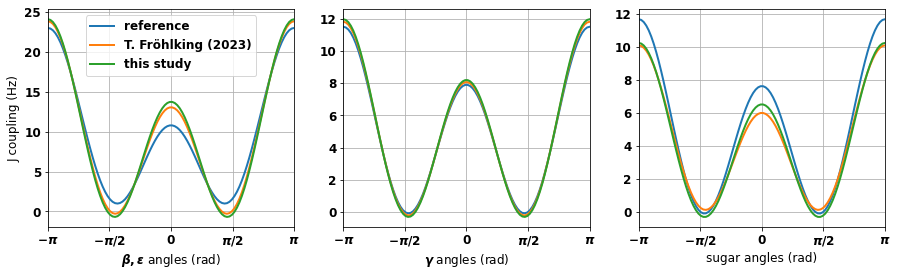

In [21]:
font = {'weight' : 'bold', 'size' : 12}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4)
fig.set_figwidth(15)

compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

# plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)
titles = [r'$\beta,\epsilon$', r'$\gamma$', 'sugar']

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='reference')

    deltaV = compute_deltaV(fm_coeffs['Thorben'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='T. Fröhlking (2023)')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s) #  ['mean'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='this study') #   (average)')

    # deltaV = compute_deltaV(fm_coeffs['100 optimal'], angles, s) #  ['mean'], angles, s)
    # axs[i].plot(angles, deltaV, '-', label='this study 2') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     axs[i].plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     axs[i].plot(angles, deltaV[k], '-', label=k)
    
    axs[i].grid()
    axs[i].set_xlabel(titles[i] + ' angles (rad)')
    # axs[i].set_title(titles[i])
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend()
axs[0].set_ylabel('J coupling (Hz)')

# plt.savefig('../Figures/Karplus_refinement_overall.png')
plt.show()

### Case 2: fully combined

Now, let's use directly `MDRefinement`.

The results will be saved in the folder `my_results`, together with those of the previous run of `MDrefinement` in the above cell.

In [22]:
starting_alpha = 1
starting_beta = 1
starting_gamma = 1

which_set = 'test'
random_states = 2

In [23]:
result2 = MDRefinement(infos, stride=stride, regularization=regularization, starting_alpha=starting_alpha, starting_beta=starting_beta,
    starting_gamma=starting_gamma, random_states=random_states, which_set=which_set, results_folder_name='my_results')

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done

search for optimal hyperparameters ...
Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 0.0), ('beta', 0.0), ('gamma', 0.0)]
av. chi2:  1830.4253310571844
av. gradient:  [-6958.63688625   101.04083815   614.30748105]

log10 hyperpars:  [('alpha', 0.9960217809785651), ('beta', -0.01446244102215403), ('gamma', -0.08792866208448787)]
av. chi2:  204.9105755011189
av. gradient:  [-132.13064023    8.88285508   -0.54557388]

log10 hyperpars:  [('alpha', 1.0153045368317617), ('beta', -0.015777925188259094), ('gamma', -0.08781547430358187)]
av. chi2:  202.53116719151382
av. gradient:  [-1.11474678e+02  7.82338611e+00 -1.06164933e-01]

optimal hyperparameters: alpha: 10.35868285663281 beta: 0.9643219999154881 gamma: 0.8169293995907795

refinement with optimal hyperparamet

In [24]:
print(vars(result2).keys())

print(result2.optimal_hyperpars)

opt_alpha = result2.optimal_hyperpars['alpha']
opt_beta = result2.optimal_hyperpars['beta']
opt_gamma = result2.optimal_hyperpars['gamma']

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new', 'optimal_hyperpars', 'hyper_minimization'])
{'alpha': 10.35868285663281, 'beta': 0.9643219999154881, 'gamma': 0.8169293995907795}


In [25]:
if not np.isinf(opt_beta):
    temp = infos['global']['names_ff_pars']
    my_ff_coeffs = pandas.Series(result2.pars[:len(temp)], index=temp)
    print(my_ff_coeffs)

if not np.isinf(opt_gamma):
    fm_names = list(data.properties.forward_coeffs_0.keys())
    my_fm_coeffs = pandas.Series(result2.pars[-len(fm_names):], index=fm_names)
    print(my_fm_coeffs)
    
    fm_coeffs['mine 2'] = my_fm_coeffs

sin alpha    0.213680
cos alpha   -0.810651
dtype: float64
A_gamma    10.296806
B_gamma    -1.841409
C_gamma    -0.231946
A_beta     18.929252
B_beta     -5.303369
C_beta     -0.213634
A_sugar     8.568608
B_sugar    -1.841163
C_sugar    -0.195276
dtype: float64


### Compare the two refinements

Compare results from HPC calculations performed on the cluster as explained in the paper https://arxiv.org/pdf/2411.07798, stored in the `Examples/Results` directories.

#### loading values
load from external folders containing results of previous cells

In [26]:
path = '../Examples/Results'
dir_list = os.listdir(path)

dir_list

['2_Result_last_2024_10_01_13_36_53_483051',
 '2_Result_last_2024_10_02_14_27_55_647283',
 '2_Result_last_2024_10_02_16_02_50_308496',
 '2_Result_last_2024_10_02_19_38_45_268929',
 '2_Result_last_2024_10_03_12_35_46_920644',
 '2_Result_last_2024_10_04_08_24_52_792385',
 'alchemical_calculations',
 'fm_coeffs_Thorben_ref',
 'original_fm_coeffs']

In [27]:
my_str = '2_Result_last_'
my_list = [s for s in dir_list if s.startswith(my_str)]
df_input = pandas.concat([pandas.read_csv(path + '/' + s + '/' 'input', index_col=0) for s in my_list])

df_input = df_input.sort_values(by='ftol')

df_input

,stride,starting_alpha,starting_beta,starting_gamma,random_states,which_set,gtol,ftol
2024_10_01_13_36_53_483051,100,1,inf,1,"[1, 2, 3, 4, 5]",test,0.5,0.00001
2024_10_03_12_35_46_920644,100,1,1.0,1,"[1, 2, 3, 4, 5]",test,0.5,0.00001
2024_10_04_08_24_52_792385,10,1,inf,1,"[1, 2, 3, 4, 5]",test,0.5,0.00001
2024_10_02_14_27_55_647283,10,1,inf,1,"[1, 2, 3, 4, 5]",test,0.5,0.01000
2024_10_02_16_02_50_308496,100,1,1.0,1,"[1, 2, 3, 4, 5]",test,0.5,0.01000
2024_10_02_19_38_45_268929,10,1,1.0,1,"[1, 2, 3, 4, 5]",test,0.5,0.01000


In [28]:
my_list = df_input.index

my_list

Index(['2024_10_01_13_36_53_483051', '2024_10_03_12_35_46_920644',
       '2024_10_04_08_24_52_792385', '2024_10_02_14_27_55_647283',
       '2024_10_02_16_02_50_308496', '2024_10_02_19_38_45_268929'],
      dtype='object')

In [29]:
my_df = pandas.concat([pandas.read_csv(path + '/' + my_str + s + '/result', index_col=0) for s in my_list])
my_df[['optimal alpha', 'optimal beta', 'optimal gamma']]

,optimal alpha,optimal beta,optimal gamma
2024_10_01_13_36_53_483051,46.308959,NaN,0.958824
2024_10_03_12_35_46_920644,959.856495,167.935942,0.421759
2024_10_04_08_24_52_792385,19.205697,NaN,0.800527
2024_10_02_14_27_55_647283,10.792865,NaN,0.862106
2024_10_02_16_02_50_308496,841.888120,158.282418,0.425229
2024_10_02_19_38_45_268929,11.100957,0.041757,0.968467


select folders to be analysed: ER+FFR and ER+FFR+FMR

In [30]:
# my_list = [df_input.iloc[-3].name, df_input.iloc[-1].name]  # stride = 10
my_list = [df_input.iloc[0].name, df_input.iloc[1].name]  # stride = 100

# ER+FFR and ER+FFR+FMR
df_result = pandas.concat([
    pandas.read_csv(path + '/' + my_str + my_list[1] + '/' + 'result', index_col=0),  # ER+FMR+FFR
    pandas.read_csv(path + '/' + my_str + my_list[0] + '/' + 'result', index_col=0)  # ER+FMR
    ])

df_result.index = ['E+FM+FF ref', 'E+FM ref']
df_result

,loss,sin alpha,cos alpha,A_gamma,B_gamma,C_gamma,A_beta,B_beta,C_beta,A_sugar,...,chi2_AAAA,chi2_CAAU,chi2_CCCC,chi2_GACC,chi2_UUUU,chi2_UCAAUC,optimal alpha,optimal beta,optimal gamma,hyper_mini success
E+FM+FF ref,1765.300623,0.584072,-0.791454,9.915804,-1.757341,-0.116239,18.128530,-5.288647,0.07166,6.986191,...,120.535372,98.730666,56.247744,31.282016,178.522105,805.854758,959.856495,167.935942,0.421759,True
E+FM ref,381.026229,NaN,NaN,9.950988,-1.858315,-0.107576,18.907471,-5.230515,-0.21221,8.335141,...,43.166862,29.767058,18.449176,19.622261,24.415580,214.539056,46.308959,NaN,0.958824,True


#### plot forward-model and force-field corrections

In [31]:
fm_names = list(data.properties.forward_coeffs_0.keys())

In [32]:
fm_names = list(data.properties.forward_coeffs_0.keys())

fm_coeffs_0 = pandas.read_csv('Results/original_fm_coeffs', index_col=0, header=None)[1]
fm_coeffs_Thorben = pandas.read_csv('Results/fm_coeffs_Thorben_ref', index_col=0, header=None)[1]

# hyperparameters derived by Thorben with chi2 and chi2 + R regularizations respectively
mini1_hyperpars = {'alpha': 85.3167852417281, 'beta': 0.019306977288832506*2}
mini2_hyperpars = {'alpha': 174.33288221999874, 'beta': 3.433320018281997*2} # those for fm_coeffs_Thorben

fm_coeffs = {}
fm_coeffs['original'] = fm_coeffs_0
fm_coeffs['Thorben'] = fm_coeffs_Thorben
fm_coeffs['mine'] = df_result.loc['E+FM+FF ref'][fm_names].to_dict()
fm_coeffs['mine 2'] = df_result.loc['E+FM ref'][fm_names].to_dict()

print(fm_coeffs)

{'original': 0
A_gamma     9.70
B_gamma    -1.80
C_gamma     0.00
A_beta     15.30
B_beta     -6.10
C_beta      1.60
A_sugar     9.67
B_sugar    -2.03
C_sugar     0.00
Name: 1, dtype: float64, 'Thorben': 0
A_gamma    10.07
B_gamma    -1.87
C_gamma    -0.13
A_beta     18.34
B_beta     -5.39
C_beta      0.11
A_sugar     7.81
B_sugar    -2.05
C_sugar     0.25
Name: 1, dtype: float64, 'mine': {'A_gamma': 9.915804477496463, 'B_gamma': -1.7573411916099333, 'C_gamma': -0.11623904080321812, 'A_beta': 18.128529765148407, 'B_beta': -5.288647464011226, 'C_beta': 0.07166022008452484, 'A_sugar': 6.986191331483642, 'B_sugar': -1.6351213139306129, 'C_sugar': 0.6677024058694986}, 'mine 2': {'A_gamma': 9.950987621703018, 'B_gamma': -1.8583152993650447, 'C_gamma': -0.10757588775476712, 'A_beta': 18.907471345868963, 'B_beta': -5.230514520283647, 'C_beta': -0.2122097463198908, 'A_sugar': 8.335140504086137, 'B_sugar': -1.8111170624383972, 'C_sugar': -0.0687174958684989}}


In [33]:
fm_coeffs['mine 2b'] = {'A_gamma': 9.77, 'B_gamma': -1.83, 'C_gamma': -0.057, 'A_beta': 16.80, 'B_beta': -5.66, 'C_beta': 0.94, 'A_sugar': 8.68, 'B_sugar': -1.81, 'C_sugar': -0.049}


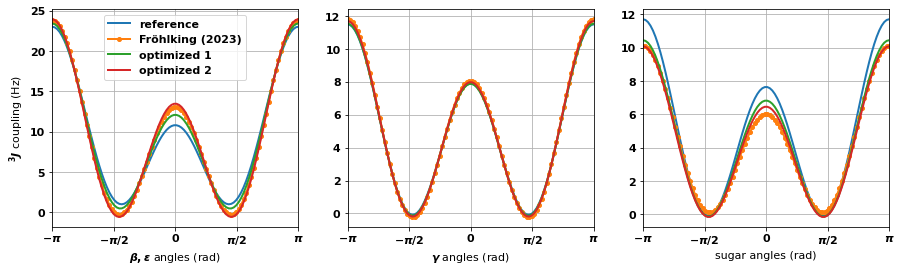

In [34]:
font = {'weight' : 'bold', 'size' : 11}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 8

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4)
fig.set_figwidth(15)

compute_karplus = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

# plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)
titles = [r'$\beta,\epsilon$', r'$\gamma$', 'sugar']

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    karplus = {}

    karplus = compute_karplus(fm_coeffs['original'], angles, s)
    axs[i].plot(angles, karplus, '-', label='reference')

    karplus = compute_karplus(fm_coeffs['Thorben'], angles, s)
    axs[i].plot(angles, karplus, '.-', label='Fröhlking (2023)')

    karplus = compute_karplus(fm_coeffs['mine 2b'], angles, s)
    axs[i].plot(angles, karplus, '-', label='optimized 1')

    karplus = compute_karplus(fm_coeffs['mine 2'], angles, s)
    axs[i].plot(angles, karplus, '-', label='optimized 2')  # (E + FM) Ref')

    # karplus = compute_karplus(fm_coeffs['mine'], angles, s)
    # axs[i].plot(angles, karplus, '-', label='(E + FM + FF) Ref')

    # karplus = compute_karplus(fm_coeffs['100 optimal'], angles, s) #  ['mean'], angles, s)
    # axs[i].plot(angles, karplus, '-', label='this study 2') #   (average)')

    # for j in range(n_seeds):
    #     karplus = compute_karplus(fm_coeffs['mine'][j], angles, s)
    #     axs[i].plot(angles, karplus, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     karplus[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     axs[i].plot(angles, karplus[k], '-', label=k)
    
    axs[i].grid()
    axs[i].set_xlabel(titles[i] + ' angles (rad)')
    # axs[0].set_ylim(top=27)
    # axs[i].set_title(titles[i])
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend()
axs[0].set_ylabel('$^3J$ coupling (Hz)')

# plt.savefig('../../Figures/Karplus_refinement_optimized.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [35]:
my_ff_coeffs = df_result.loc['E+FM+FF ref'][['sin alpha', 'cos alpha']].to_dict()

ff_coeffs = {'this study': my_ff_coeffs,
    'FFR': {'sin alpha': 0.91, 'cos alpha': 1.67},
    'ER+FFR': {'sin alpha': 0.51, 'cos alpha': 1.65}}

In [36]:
ff_coeffs

{'this study': {'sin alpha': 0.5840721894788735,
  'cos alpha': -0.7914544075926866},
 'FFR': {'sin alpha': 0.91, 'cos alpha': 1.67},
 'ER+FFR': {'sin alpha': 0.51, 'cos alpha': 1.65}}

Text(0, 0.5, '$\\Delta V \\, (k_B T)$')

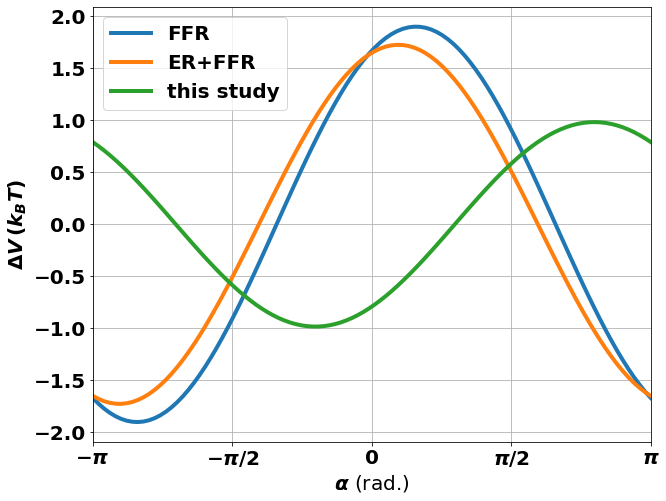

In [37]:
font = {'weight' : 'bold', 'size' : 20}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 10

angles = np.linspace(-np.pi, np.pi, 100)

plt.figure(figsize=(10, 8))

deltaV = {}

labels = ['FFR', 'ER+FFR', 'this study']

for i, s in enumerate(labels):
    deltaV[s] = ff_coeffs[s]['cos alpha']*np.cos(angles) + ff_coeffs[s]['sin alpha']*np.sin(angles)

    plt.plot(angles, deltaV[s], '-', label=labels[i])

plt.legend()
plt.grid()
# plt.title(r'force-field correction $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.ylabel('$\Delta V \, (k_B T)$')

# plt.savefig('../../Figures/deltaV.pdf', format='pdf', bbox_inches='tight')

#### load dihedral angles and new weights

In [38]:
my_angles = {}

for s in infos['global']['system_names']:

    my_angles[s] = []
    length = len(data.mol[s].f.T)//2

    for i in range(length):

        angles = np.arcsin(data.mol[s].f[:, i])
        wh = np.argwhere(data.mol[s].f[:, i + length] < 0)
        angles[wh] = np.pi - angles[wh]
        angles = np.mod(angles, 2*np.pi)

        wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
        angles[wh] = angles[wh] - 2*np.pi

        my_angles[s].append(angles)

In [39]:
os.listdir('../Examples/Results/')  # 2_Result_last_original/')

['2_Result_last_2024_10_01_13_36_53_483051',
 '2_Result_last_2024_10_02_14_27_55_647283',
 '2_Result_last_2024_10_02_16_02_50_308496',
 '2_Result_last_2024_10_02_19_38_45_268929',
 '2_Result_last_2024_10_03_12_35_46_920644',
 '2_Result_last_2024_10_04_08_24_52_792385',
 'alchemical_calculations',
 'fm_coeffs_Thorben_ref',
 'original_fm_coeffs']

In [40]:
weights_new = {}
weights_new['E+FM ref'] = {}
weights_new['E+FM+FF ref ff'] = {}
weights_new['E+FM+FF ref'] = {}

for s in infos['global']['system_names']:
    weights_new['E+FM ref'][s] = np.load(path + '/' + my_str + my_list[0] + '/' + '/weights_new_%s.npy' % s)
    weights_new['E+FM+FF ref ff'][s] = np.load(path + '/' + my_str + my_list[1] + '/' + '/weights_ff_%s.npy' % s)
    weights_new['E+FM+FF ref'][s] = np.load(path + '/' + my_str + my_list[1] + '/' + '/weights_new_%s.npy' % s)

In [41]:
from MDRefine import compute_new_weights

In [42]:
for s2 in ['FFR', 'ER+FFR']:

    pars = np.array(list(ff_coeffs[s2].values()))
    
    weights_new[s2] = {}
    
    for s in infos['global']['system_names']:
        correction = data.mol[s].ff_correction(pars, data.mol[s].f)/data.mol[s].temperature
        weights_new[s2][s] = compute_new_weights(data.mol[s].weights, correction)[0]

#### visualize the hypersearch

In [43]:
my_list

['2024_10_01_13_36_53_483051', '2024_10_03_12_35_46_920644']

In [44]:
dfs_hyper = {}
dfs_hyper[0] = pandas.read_csv(path + '/' + my_str + my_list[0] + '/' + 'hyper_search', index_col=0)

dfs_hyper[0]

,av_chi2,av_gradient alpha,log10_hyperpars alpha,av_gradient gamma,log10_hyperpars gamma
0,1.494645e+06,-83484.150525,0.000000,6864.549112,0.000000
1,3.640039e+03,-7654.440449,0.996637,-1.041580,-0.081949
2,3.150122e+03,-2897.590946,1.097314,-28.726717,-0.081118
3,3.008081e+03,-1689.717108,1.158654,-25.292575,-0.079651
4,2.905336e+03,-756.889430,1.244485,-14.950528,-0.076566
5,2.863234e+03,-463.559900,1.314144,-13.941165,-0.073464
6,2.826691e+03,-248.580847,1.424348,-14.098655,-0.065650
7,2.792318e+03,-167.420569,1.552302,-17.791933,-0.049322
8,2.799691e+03,215.037340,1.823207,-19.598546,0.024903
9,2.784123e+03,-13.669974,1.665665,-19.469618,-0.018261


In [45]:
dfs_hyper[1] = pandas.read_csv(path + '/' + my_str + my_list[1] + '/' + 'hyper_search', index_col=0)

dfs_hyper[1]

,av_chi2,av_gradient alpha,log10_hyperpars alpha,av_gradient beta,log10_hyperpars beta,av_gradient gamma,log10_hyperpars gamma
0,1.492265e+06,-131752.250461,0.000000,4309.731730,0.000000,8201.983928,0.000000
1,6.048931e+03,-1827.753904,0.997536,-2654.318168,-0.032630,363.729927,-0.062100
2,5.961701e+03,-2436.721936,1.012011,-2661.525493,-0.012005,354.180727,-0.064944
3,5.521062e+03,-4236.963742,1.069908,-2647.068794,0.070496,297.189956,-0.076320
4,3.515302e+03,-4529.681650,1.301497,-1997.389598,0.400499,89.559859,-0.121825
5,1.356018e+03,-792.276702,2.227854,522.485446,1.720510,-3.889771,-0.303847
6,1.296206e+03,302.932881,2.408530,-625.556200,1.679429,-1.133588,-0.307227
7,1.256855e+03,-139.193478,2.474971,-88.051435,1.812841,-1.460127,-0.321588
8,1.219645e+03,-221.532270,2.679677,83.958141,2.020229,-0.960379,-0.348075
9,1.235216e+03,-526.791253,3.067895,863.706156,2.368460,-0.435284,-0.392212


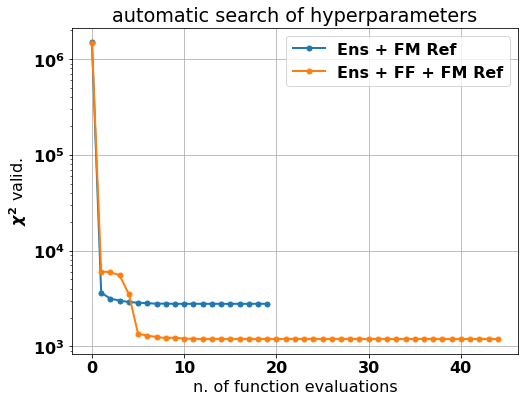

In [46]:
font = {'weight' : 'bold', 'size' : 16}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

plt.figure(figsize=(8, 6))
plt.plot(dfs_hyper[0]['av_chi2'], '.-', label='Ens + FM Ref')
plt.plot(dfs_hyper[1]['av_chi2'], '.-', label='Ens + FF + FM Ref')

plt.yscale('log')
plt.grid()
plt.xlabel('n. of function evaluations')
plt.ylabel(r'$\chi^2$ valid.')
plt.title('automatic search of hyperparameters')
plt.legend()

# plt.savefig('../../Figures/hyper_search.pdf', format='pdf', bbox_inches='tight')

#### histograms

- alpha dihedral angles

In [47]:
bins = np.arange(-np.pi, np.pi, 0.05)
my_list = ['original'] + list(weights_new.keys())

my_hists = {}

for s in my_list:
    my_hists[s] = {}
    for s2 in infos['global']['system_names']:
        my_hists[s][s2] = []

for s in infos['global']['system_names']:
    for i in range(len(my_angles[s])):
        my_hists['original'][s].append(np.histogram(my_angles[s][i], bins=bins, density=True))
        for s2 in my_list[1:]:
            my_hists[s2][s].append(np.histogram(my_angles[s][i], bins=bins, density=True, weights=weights_new[s2][s]))


In [48]:
my_list

['original', 'E+FM ref', 'E+FM+FF ref ff', 'E+FM+FF ref', 'FFR', 'ER+FFR']

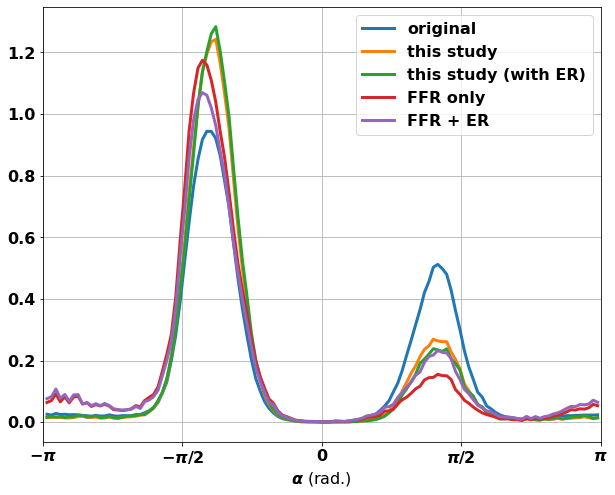

In [49]:
plt.figure(figsize=(10, 8))

tot_hist = {}

for s2 in my_list: tot_hist[s2] = np.zeros(len(my_hists['original']['AAAA'][0][0]))

counter = 0

for s in infos['global']['system_names']:
    for i in range(len(my_hists['original'][s])):
        for s2 in my_list:
            tot_hist[s2] += my_hists[s2][s][i][0]
        counter += 1

labels = ['original', 'this study', 'this study (with ER)', 'FFR only', 'FFR + ER']

x = my_hists['original'][s][i][1][1:]

# tot_hist['original'] = tot_hist['original']/counter
# plt.fill_between(x, np.zeros(len(x)), tot_hist['original'], alpha=0.4, label='original')

labels = ['original', 'this study', 'this study (with ER)', 'FFR only', 'FFR + ER']
my_sublist = ['original', 'E+FM+FF ref ff', 'E+FM+FF ref', 'FFR', 'ER+FFR']

# for i, s2 in enumerate(my_list):
for i, s2 in enumerate(my_sublist):
    tot_hist[s2] = tot_hist[s2]/counter

    # if i == 1: lw = 5
    # else: lw = 2
    lw = 3

    # plt.plot(my_hists['original'][s][i][1][1:], my_hists[s2]['AAAA'][0][0])
    plt.plot(x, tot_hist[s2], '-', label=labels[i], linewidth=lw)
    # plt.fill_between(x, np.zeros(len(x)), tot_hist[s2], alpha=0.6)

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.legend()
plt.grid()

# plt.savefig('../../Figures/tot_hist_alpha.pdf', format='pdf', bbox_inches='tight')

- forward-model dihedral angles

In [50]:
bins = np.arange(-np.pi, np.pi, 0.05)
# bins = np.arange(0, 20, 0.5)  # bins for the histograms of the 3J couplings

my_hists_fm = {}

for s in my_list:
    my_hists_fm[s] = {}
    for s2 in infos['global']['system_names']:
        my_hists_fm[s][s2] = {}
        for s3 in data.mol[s2].forward_qs.keys():
            my_hists_fm[s][s2][s3] = []

for s in infos['global']['system_names']:
    for s2 in data.mol[s].forward_qs.keys():
        for i in range(data.mol[s].forward_qs[s2].shape[1]):
            my_hists_fm['original'][s][s2].append(np.histogram(data.mol[s].forward_qs[s2][:, i], bins=bins, density=True))
            for s3 in my_list[1:]:
                my_hists_fm[s3][s][s2].append(np.histogram(data.mol[s].forward_qs[s2][:, i], bins=bins, density=True, weights=weights_new[s3][s]))


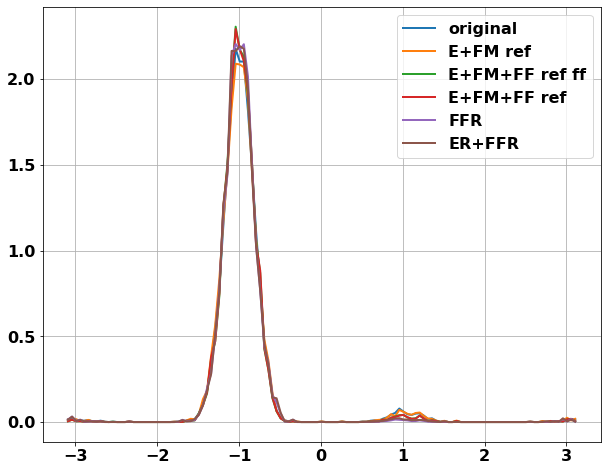

In [51]:
plt.figure(figsize=(10, 8))

for s in my_list:
    my_var = my_hists_fm[s]['AAAA']['backbone1_gamma'][2]
    plt.plot(my_var[1][1:], my_var[0], '-', label=s)

plt.legend()
plt.grid()

#### relative entropy and chi2

In [52]:
def plot_DataFrame(df, labels=None, xticks_name=None):

        barWidth = 1/(len(df.columns) + 1)

        plt.subplots(figsize=(12, 8)) 

        brs = []
        brs.append(np.arange(len(df.iloc[:, 0])))

        if labels == None: labels = df.columns
        if xticks_name == None: xticks_name = list(df.index)
        
        plt.bar(brs[-1], df.iloc[:, 0], label=labels[0], width=barWidth)  # edgecolor ='grey', color ='tab:blue')

        for i in range(1, len(df.columns)):
                brs.append([x + barWidth for x in brs[-1]])
                plt.bar(brs[-1], df.iloc[:, i], label=labels[i], width=barWidth)  # edgecolor ='grey', color ='tab:blue')

        plt.xticks([r + barWidth*(len(df.columns) - 1)/2 for r in range(len(df.iloc[:, 0]))], xticks_name)
        # plt.xticks([r + barWidth for r in range(len(df.iloc[:, 0]))], list(df.index))
        # plt.xlabel(list(df.index))
        
        # plt.xlabel('Branch', fontweight ='bold', fontsize = 15) 
        # plt.ylabel('Students passed', fontweight ='bold', fontsize = 15) 
        # plt.xticks([r + barWidth for r in range(len(df['Aduri'].iloc[:-1]))], names_charges)

        plt.legend()
        plt.gca().xaxis.grid(True)
        # plt.grid()
        # plt.show()

        return

In [53]:
my_cols = [col for col in my_df.columns if col.startswith('D_KL_alpha')]
my_cols1 = [col for col in my_df.columns if col.startswith('reg_ff')]

my_df[my_cols1]

,reg_ff_AAAA,reg_ff_CAAU,reg_ff_CCCC,reg_ff_GACC,reg_ff_UUUU,reg_ff_UCAAUC
2024_10_01_13_36_53_483051,NaN,NaN,NaN,NaN,NaN,NaN
2024_10_03_12_35_46_920644,0.346839,0.570094,0.523402,0.260561,0.392336,0.466149
2024_10_04_08_24_52_792385,NaN,NaN,NaN,NaN,NaN,NaN
2024_10_02_14_27_55_647283,NaN,NaN,NaN,NaN,NaN,NaN
2024_10_02_16_02_50_308496,0.332866,0.539999,0.502135,0.251067,0.374712,0.435389
2024_10_02_19_38_45_268929,0.418906,0.657361,0.586903,0.312384,0.435219,1.084910


<Figure size 288x288 with 0 Axes>

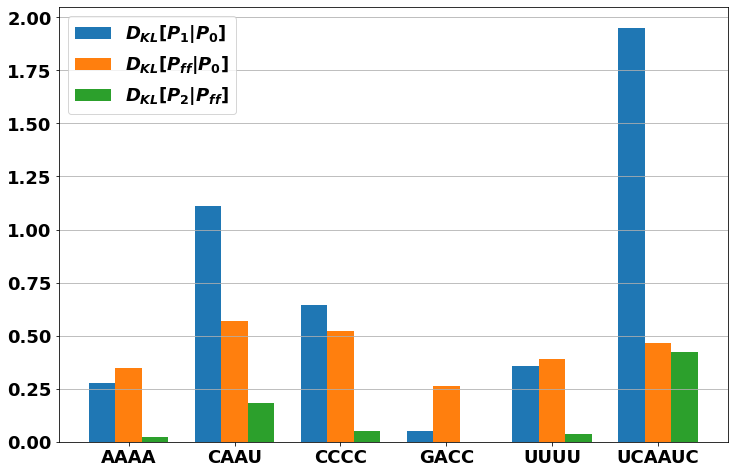

In [54]:
font = {'weight' : 'bold', 'size' : 18}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

my_dict = {'DKL ER': my_df[my_cols].iloc[0].values, 'DKL FFR': my_df[my_cols1].iloc[1].values, 'DKL ER from FFR': my_df[my_cols].iloc[1].values}

df = pandas.DataFrame(my_dict, index=data.properties.system_names)

plt.figure(figsize=(4, 4))
plot_DataFrame(df, labels=[r'$D_{KL}[P_1|P_0]$', r'$D_{KL}[P_{ff}|P_0]$', r'$D_{KL}[P_2|P_{ff}]$'])
plt.legend()
plt.grid()

# plt.savefig('../../Figures/rel_entropies.pdf', format='pdf', bbox_inches='tight')

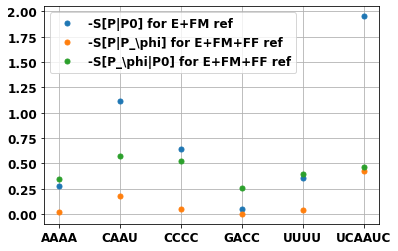

In [55]:
x = np.arange(6)

font = {'weight' : 'bold', 'size' : 12}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

plt.plot(x, my_df[my_cols].iloc[0], '.', label='-S[P|P0] for E+FM ref')
plt.plot(x, my_df[my_cols].iloc[1], '.', label='-S[P|P_\phi] for E+FM+FF ref')
plt.plot(x, my_df[my_cols1].iloc[1], '.', label='-S[P_\phi|P0] for E+FM+FF ref')

plt.xticks(x, data.properties.system_names)
plt.legend()
plt.grid()

# plt.savefig('../../Figures/rel_entropies.pdf', format='pdf', bbox_inches='tight')

In [56]:
def compute_DKL(w, w0):
    out = np.sum(w[w != 0]*np.log(w[w != 0]/w0[w != 0]))
    return out

the critical issue when computing the relative entropy from the histogram weights is that you have to select a single dihedral angle, unless you act on the "average histogram", which might be not significatively enough, due to the curse of dimensionality! You could/should compute the rel. entropy for each dihedral angle and then compare the average values...

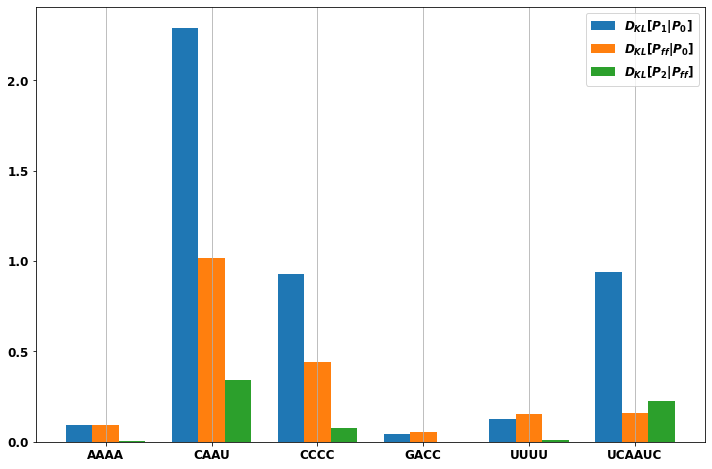

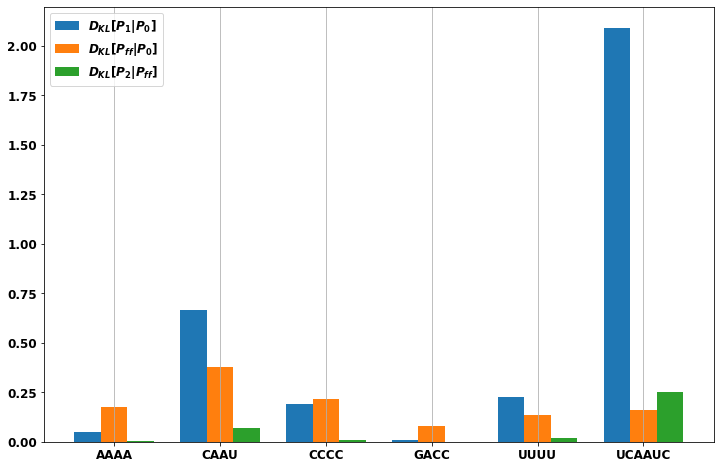

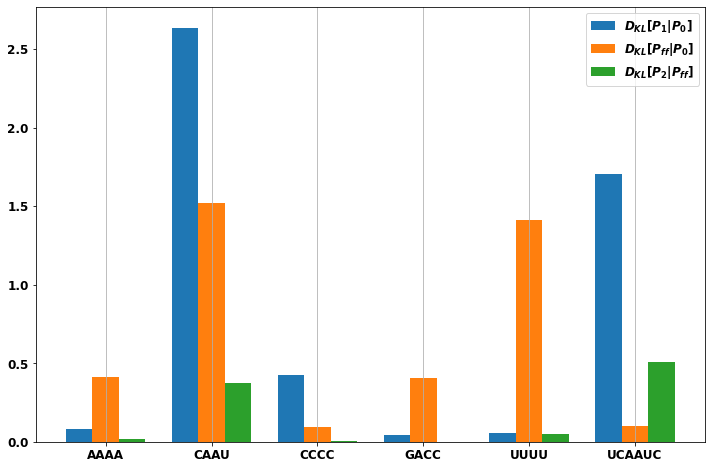

In [57]:
my_dict = {}

kinds = ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar']

for kind in kinds:
    
    for s in my_hists_fm['E+FM+FF ref ff'].keys():

        w0 = my_hists_fm['original'][s][kind][1][0]
        w_fm = my_hists_fm['E+FM ref'][s][kind][1][0]
        w_ff = my_hists_fm['E+FM+FF ref ff'][s][kind][1][0]
        w = my_hists_fm['E+FM+FF ref'][s][kind][1][0]

        my_dict[s] = [compute_DKL(w_fm, w0), compute_DKL(w_ff, w0), compute_DKL(w, w_ff)]

    this_df = pandas.DataFrame(my_dict).T

    plot_DataFrame(this_df, labels=[r'$D_{KL}[P_1|P_0]$', r'$D_{KL}[P_{ff}|P_0]$', r'$D_{KL}[P_2|P_{ff}]$'])

In [58]:
my_cols = ['optimal alpha', 'optimal beta', 'optimal gamma']

print('ER+FMR:\n', df_result.loc['E+FM ref'][[s for s in my_cols if s in df_result.columns]])

print('\n\nfully combined:\n', df_result.loc['E+FM+FF ref'][[s for s in my_cols if s in df_result.columns]])

cols = [s for s in df_result.columns if s.startswith('D_KL_alpha') or s.startswith('reg_ff')]
print('\n', df_result[cols])


ER+FMR:
 optimal alpha      46.309
optimal beta          NaN
optimal gamma    0.958824
Name: E+FM ref, dtype: object


fully combined:
 optimal alpha     959.856
optimal beta      167.936
optimal gamma    0.421759
Name: E+FM+FF ref, dtype: object

              reg_ff_AAAA  reg_ff_CAAU  reg_ff_CCCC  reg_ff_GACC  reg_ff_UUUU  \
E+FM+FF ref     0.346839     0.570094     0.523402     0.260561     0.392336   
E+FM ref             NaN          NaN          NaN          NaN          NaN   

             reg_ff_UCAAUC  D_KL_alpha_AAAA  D_KL_alpha_CAAU  D_KL_alpha_CCCC  \
E+FM+FF ref       0.466149         0.021830         0.181029         0.052605   
E+FM ref               NaN         0.276919         1.109998         0.645304   

             D_KL_alpha_GACC  D_KL_alpha_UUUU  D_KL_alpha_UCAAUC  
E+FM+FF ref         0.000185         0.039078           0.422813  
E+FM ref            0.052310         0.355849           1.951061  


In [59]:
from MDRefine import compute_chi2

In [60]:
s1_list = list(weights_new.keys())
print(s1_list)

chi2_values = {}

for s1 in s1_list:
    chi2_values[s1] = {}
    for s in data.properties.system_names:
        chi2_values[s1][s] = compute_chi2(data.mol[s].ref, weights_new[s1][s], data.mol[s].g, data.mol[s].gexp)[1]


['E+FM ref', 'E+FM+FF ref ff', 'E+FM+FF ref', 'FFR', 'ER+FFR']


In [61]:
chi2_values['original'] = {}

for s in data.properties.system_names:
    chi2_values['original'][s] = compute_chi2(data.mol[s].ref, data.mol[s].weights, data.mol[s].g, data.mol[s].gexp)[1]


In [62]:
for s in data.properties.system_names:
    print(data.mol[s].n_experiments)

{'backbone1_gamma_3J': 8, 'backbone2_beta_epsilon_3J': 9, 'sugar_3J': 11, 'NOEs': 36}
{'backbone1_gamma_3J': 8, 'backbone2_beta_epsilon_3J': 8, 'sugar_3J': 11, 'NOEs': 39}
{'backbone1_gamma_3J': 6, 'backbone2_beta_epsilon_3J': 9, 'sugar_3J': 11, 'NOEs': 27}
{'backbone1_gamma_3J': 8, 'backbone2_beta_epsilon_3J': 9, 'sugar_3J': 12, 'NOEs': 20}
{'backbone1_gamma_3J': 6, 'backbone2_beta_epsilon_3J': 9, 'sugar_3J': 10, 'NOEs': 9}
{'backbone1_gamma_3J': 11, 'backbone2_beta_epsilon_3J': 14, 'sugar_3J': 13, 'NOEs': 64}


In [63]:
chi2s = {}

for s1 in ['original'] + s1_list:
    chi2s[s1] = {}
    for s2 in chi2_values[s1][s].keys():
        chi2s[s1][s2] = np.sum([chi2_values[s1][s][s2] for s in data.properties.system_names])


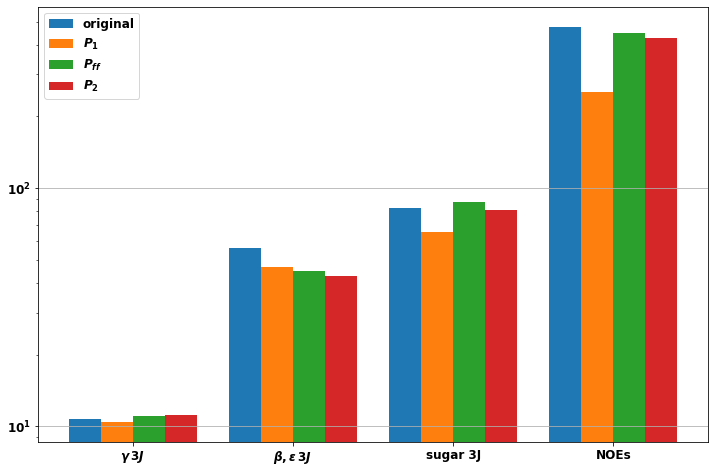

In [64]:
chi2s_df = pandas.DataFrame(chi2s)
xticks_name = ['$\gamma \, 3J$', r'$\beta, \epsilon \, 3J$', 'sugar 3J', 'NOEs']  # , 'uNOEs']

plot_DataFrame(chi2s_df.iloc[:, :-2], labels=['original', '$P_1$', '$P_{ff}$', '$P_2$'], xticks_name=xticks_name)
plt.yscale('log')
plt.grid()

# plt.savefig('../../Figures/chi2s.pdf', format='pdf', bbox_inches='tight')


##### other histograms

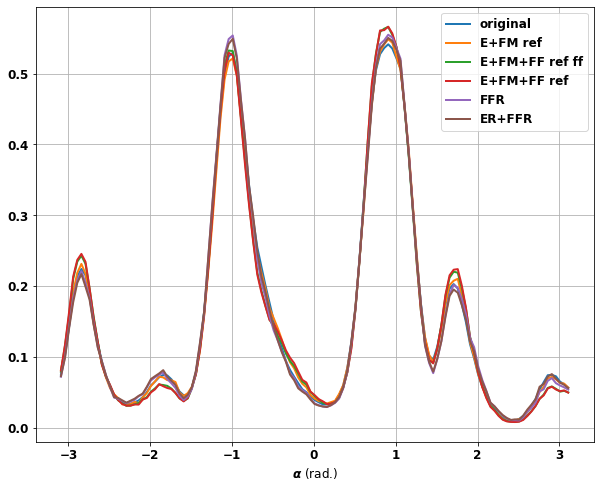

In [65]:
plt.figure(figsize=(10, 8))

tot_hist = {}

for s2 in my_list: tot_hist[s2] = np.zeros(len(my_hists_fm['original']['AAAA']['backbone1_gamma'][0][0]))

counter = 0

for s in infos['global']['system_names']:
    for s1 in my_hists_fm['original'][s].keys():
        for i in range(len(my_hists_fm['original'][s][s1])):
            for s2 in my_list:
                tot_hist[s2] += my_hists_fm[s2][s][s1][i][0]
            counter += 1

# labels = ['original', 'this study', 'this study (with ER)', 'FFR only', 'FFR + ER']

x = my_hists_fm['original'][s][s1][i][1][1:]

# tot_hist['original'] = tot_hist['original']/counter
# plt.fill_between(x, np.zeros(len(x)), tot_hist['original'], alpha=0.4, label='original')

for i, s2 in enumerate(my_list):
    tot_hist[s2] = tot_hist[s2]/counter

    # if i == 1: lw = 5
    # else:
    lw = 2

    # plt.plot(my_hists_fm['original'][s][i][1][1:], my_hists_fm[s2]['AAAA'][0][0])
    plt.plot(x, tot_hist[s2], '-', label=s2, linewidth=lw)
    # plt.fill_between(x, np.zeros(len(x)), tot_hist[s2], alpha=0.6)

# plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
# plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.legend()
plt.grid()

# plt.savefig('../../Figures/tot_hist_Karplus_angles.pdf', format='pdf', bbox_inches='tight')

In [66]:
data.mol[s].g['NOEs'][:, i][::10].shape

weights_new[s3][s].shape

(10120,)

In [67]:
print([np.max(data.mol[s].g['NOEs']) for s in infos['global']['system_names']])

bins = np.arange(-0.001, 0.05, 0.001)

my_hists_NOEs = {}

for s in my_list:
    my_hists_NOEs[s] = {}
    for s2 in infos['global']['system_names']:
        my_hists_NOEs[s][s2] = []

for s in infos['global']['system_names']:
    for i in range(data.mol[s].g['NOEs'].shape[1]):
        my_hists_NOEs['original'][s].append(np.histogram(data.mol[s].g['NOEs'][:, i], bins=bins, density=True))
        for s3 in my_list[1:]:
            my_hists_NOEs[s3][s].append(np.histogram(data.mol[s].g['NOEs'][:, i], bins=bins, density=True, weights=weights_new[s3][s]))


[0.03321244, 0.035759673, 0.033241194, 0.037689257, 0.02605617, 0.030193683]


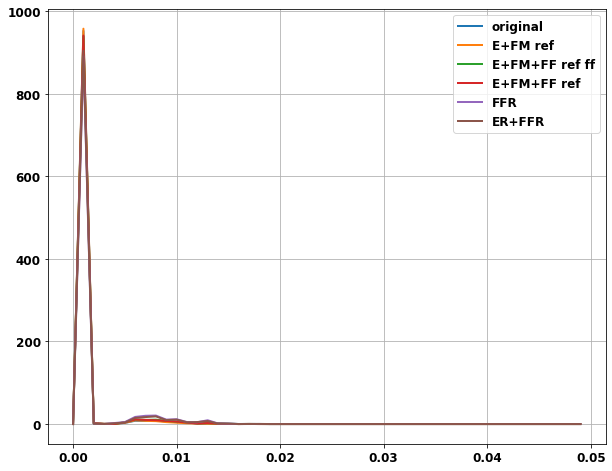

In [68]:
plt.figure(figsize=(10, 8))

for s in my_list:
    # for s2 in infos['global']['system_names']:
    my_var = my_hists_NOEs[s]['CAAU'][0]
    plt.plot(my_var[1][1:], my_var[0], '-', label=s)

plt.legend()
plt.grid()

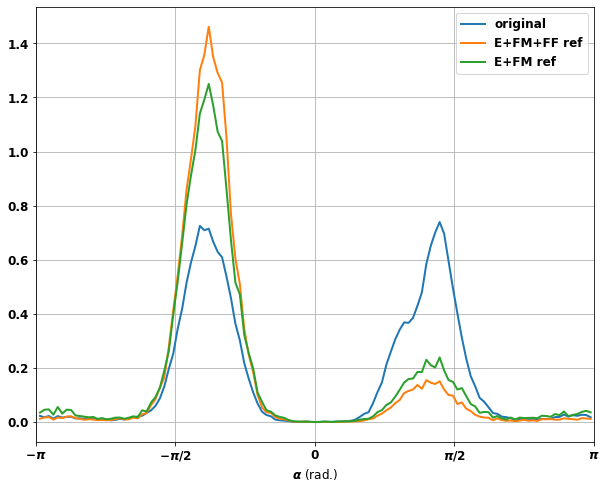

In [69]:
s = 'CAAU'

plt.figure(figsize=(10, 8))

x = my_hists['original'][s][0][1][1:]

for s2 in ['original', 'E+FM+FF ref', 'E+FM ref']:
    hist = np.mean(np.array([my_hists[s2][s][i][0] for i in range(len(my_hists['original'][s]))]), axis=0)
    plt.plot(x, hist, label=s2)

# plt.plot(x, my_hists['original'][s][1][0], label='E+FM+FF ref')
# plt.plot(x, my_hists['E+FM+FF ref'][s][1][0], label='E+FM+FF ref')
# plt.plot(x, my_hists['E+FM ref'][s][1][0], label='E+FM ref')

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.legend()
plt.grid()

dict_keys(['E+FM ref', 'E+FM+FF ref ff', 'E+FM+FF ref', 'FFR', 'ER+FFR'])


<Figure size 432x288 with 0 Axes>

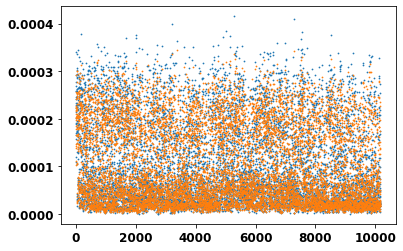

<Figure size 432x288 with 0 Axes>

In [70]:
print(weights_new.keys())

s2 = 'E+FM+FF ref ff'
s = 'AAAA'

plt.plot(weights_new['E+FM+FF ref'][s], '.', markersize=1.5)
plt.plot(weights_new[s2][s], '.', markersize=1.5)

plt.figure()

dict_keys(['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'])


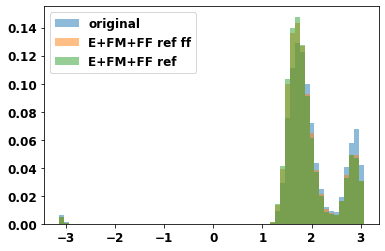

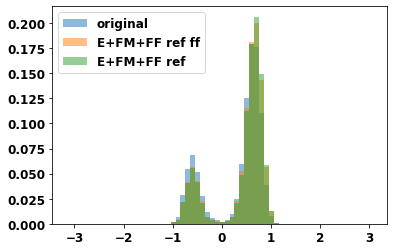

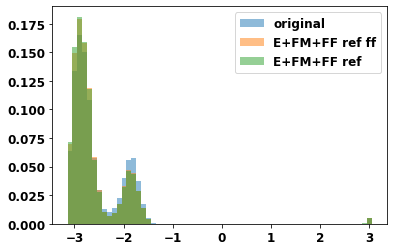

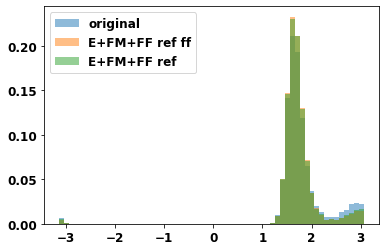

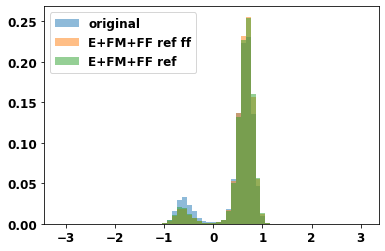

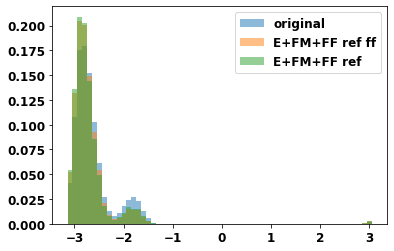

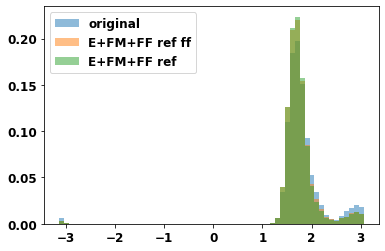

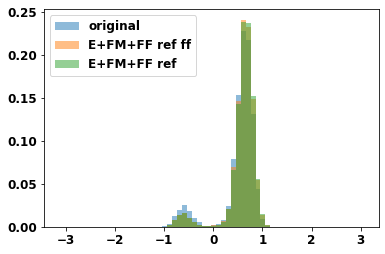

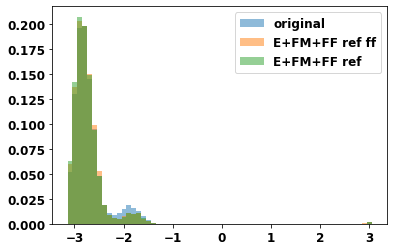

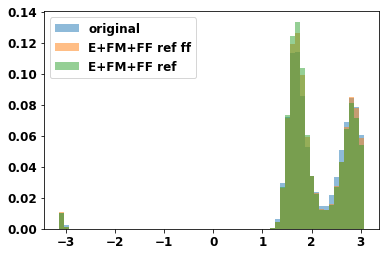

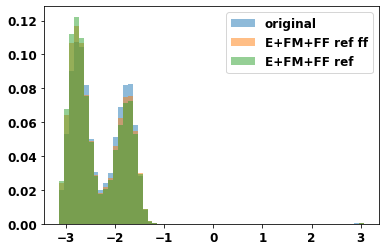

In [71]:
print(data.mol[s].forward_qs.keys())

angles = data.mol[s].forward_qs['sugar']
bins = np.arange(-np.pi, np.pi, 0.1)

for i in range(angles.shape[1]):
    plt.figure()
    plt.hist(angles[:, i], bins, weights=data.mol[s].weights, alpha=0.5, label='original')[2]
    plt.hist(angles[:, i], bins, weights=weights_new['E+FM+FF ref ff'][s], alpha=0.5, label='E+FM+FF ref ff')[2]
    plt.hist(angles[:, i], bins, weights=weights_new['E+FM+FF ref'][s], alpha=0.5, label='E+FM+FF ref')[2]
    plt.legend()

##### ratio for a specific refinement

next, let's focus on a refinement **s2** and a single system **s**:
- plot original and new weights; compute their ratio and plot it;
- compute the Kish size and the relative Kish size;
- plot angle vs. ratio

In [72]:
s2 = 'FFR'
s = 'AAAA'

In [73]:
w0 = data.mol[s].weights
w1 = weights_new['E+FM+FF ref ff'][s]
w2 = weights_new['E+FM+FF ref'][s]

relS = np.sum(w2*np.log(w2/w1))
print(relS)

relS = np.sum(w1*np.log(w1/w0))
print(relS)

relS = np.sum(w2*np.log(w2/w0))
print(relS)

0.02183041903581102
0.3468386102371521
0.37598970093184547


In [74]:
s2 = 'E+FM+FF ref ff'

6006.955360944868
1.6930373856482772


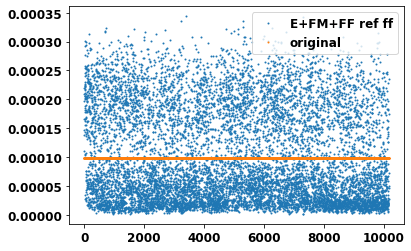

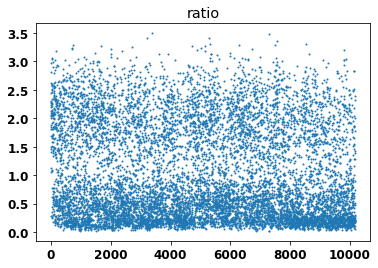

In [75]:
plt.plot(weights_new[s2][s], '.', markersize=2, label=s2)
plt.plot(data.mol[s].weights, '.', markersize=2, label='original')
plt.legend()

plt.figure()
ratio = weights_new[s2][s]/data.mol[s].weights
# ratio = weights_new['E+FM+FF ref'][s]/weights_new['E+FM+FF ref ff'][s]
plt.plot(ratio, '.', markersize=2)
plt.title('ratio')
# plt.yscale('log')

Kish = 1/np.sum(weights_new[s2][s]**2)

print(Kish)
# print(np.exp(-Result.D_KL_alpha[s]))

rel_kish = np.sum(weights_new[s2][s]**2/data.mol[s].weights)
print(rel_kish)

6


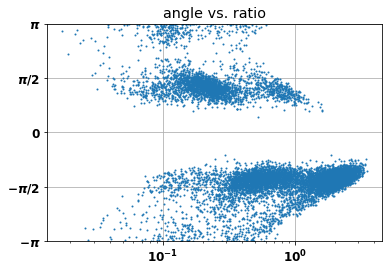

In [76]:
length = len(data.mol[s].f.T)//2
print(length)

i = 0

angles = np.arcsin(data.mol[s].f[:, i])
wh = np.argwhere(data.mol[s].f[:, i + length] < 0)
angles[wh] = np.pi - angles[wh]
angles = np.mod(angles, 2*np.pi)

wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
angles[wh] = angles[wh] - 2*np.pi

plt.plot(ratio, angles, '.', markersize=2)
plt.xscale('log')
plt.title('angle vs. ratio')
plt.ylim([-np.pi, np.pi])
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.grid()

here it's evident that negative angles are favoured by the reweighting w.r.t. positive angles; if instead we look at the dihedral angles used in the forward model, there is not such a correlation

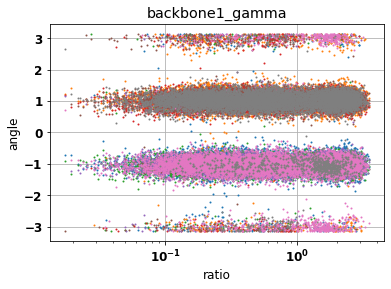

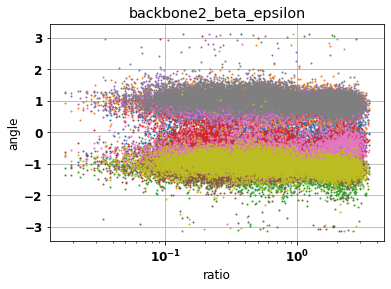

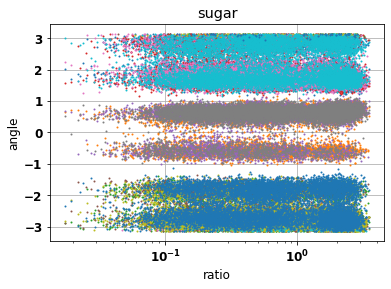

In [77]:
for key in data.mol[s].forward_qs.keys():

    plt.figure()
    plt.title(key)
    
    length = len(data.mol[s].forward_qs[key].T)
    
    for i in range(length):
        angles = data.mol[s].forward_qs[key][:, i]
        plt.plot(ratio, angles, '.', markersize=2)
    
    plt.xscale('log')
    plt.xlabel('ratio')
    plt.ylabel('angle')
    plt.grid()
    plt.show()